# Improved Discretization of Action

We made the connection earlier between our continous representation of our euclidean correlator and the path ingeral. We will now start from our path integral 

xxxxxxxxxxx


Integrating S by parts we obtain

xxxxxxxxxxxx

The second order finite central difference for second derivatives gives our numerical action as

xxxxxxxxx

We can add a correction term of the form

xxxxxxxxxx

to our action to further improve accuracy to fourth order in a. This can also be derived by computing 

xxxxxxxxxxx x(t+2h) + x(t-2h) expanded

### Potentials

We only work with the harmonic oscillator

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import vegas
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

#Harmonic
def v_sho(x):
    
    return (x**2)/2

### Actions

In [352]:
def action_original(x, i, v, m, a): 
    ir = (i+1)%len(x) 
    il = (i-1)%len(x)
    return a *  v(x[i]) + (m/a) * x[i] * (x[i]-x[il]-x[ir])

def action_improved(x, i, v, m, a):
    ir1 = (i+1)%len(x)
    ir2 = (i+2)%len(x)
    il1 = (i-1)%len(x)
    il2 = (i-2)%len(x)
    return a *  v(x[i]) + (m/(12*a)) * x[i] * (x[il2]-16*x[il1]+15*x[i]-16*x[ir1]+x[ir2])

### Update function

In [353]:
def update(x, v, m, a, dx, action):
    #Updates Every Point Once
    accept = 0
    for i in range(len(x)):
        
        x_old = x[i]
        old_action = action(x=x, i=i, v=v, m=m, a=a)
        
        x[i] += np.random.uniform(-dx, dx)
        new_action = action(x=x, i=i, v=v, m=m, a=a)
        
        diff = old_action - new_action
        
        r = np.minimum(1.0, np.exp(diff))
    
        if r < np.random.rand():
            x[i] = x_old
        
        else:
            accept += 1
    
    return x, accept / len(x)

### Correlator

In [354]:
def G(x):
    #Returns Array Gn = [G1, G2,...]
    n = len(x)
    g = np.zeros(n)
    for j in range(n):
        for i in range(n):
            g[j] += (x[(i+j)%(n)]) *(x[i])
            
    return g/n

### Function to generate ensembles

In [355]:
def markov_chain(n_sites, n_configs, v, m, a, dx, n_corr, action):
    
    acceptance = 0
    config = np.zeros((n_sites))
    gn = []
    
    #Thermalise
    for i in range(10*n_corr):
        config = update(config, v, m, a, dx, action)[0]


    for i in range(n_configs*n_corr):
        config, acc = update(config, v, m, a, dx, action)
        acceptance += acc
        
        if i % n_corr == 0:
            gn.append(G(config))
            
    acceptance = acceptance / (n_configs*n_corr)       
    return gn, acceptance

### Analysis

In [356]:
def binning(g, bin_size):
    g_binned = []
    for i in range(0, len(g), bin_size):
        bin_val = np.mean(g[i:i+bin_size],0)
        g_binned.append(bin_val)

    return g_binned


def analysis(n_sites, n_cfs_arr, v, m, a, dx, n_corr, bin_size):
    
    rows = len(n_cfs_arr)
    fig, axs =  plt.subplots(nrows=rows, ncols=2, sharex='col', figsize=(12, 10), dpi=100)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    ax = axs.flat
    
    for i, n_configs in enumerate(n_cfs_arr):
        
        gn, acc = markov_chain(n_sites=n_sites, n_configs=n_configs * bin_size, v=v, m=m, a=a, dx=dx, n_corr=n_corr, action = action_original)
        gn_improved, acc_improved = markov_chain(n_sites=n_sites, n_configs=n_configs * bin_size, v=v, m=m, a=a, dx=dx, n_corr=n_corr, action = action_improved)
        binned_g = binning(g=gn, bin_size=bin_size)
        binned_g_improved = binning(g=gn_improved, bin_size=bin_size)
        
        #############################################################################################
        #Original Action
        
        avg_binned = np.mean(binned_g, 0)
        err_binned = np.std(binned_g, 0)
        avg_shift_binned = np.roll(avg_binned, -1)
        err_shift_binned = np.roll(err_binned, -1)
        
        E_eff_binned = np.log(np.divide(avg_binned, avg_shift_binned)) / a
        E_eff_err_binned = np.sqrt(np.divide(err_binned, avg_binned)**2 + np.divide(err_shift_binned, avg_shift_binned)**2)/ a / np.sqrt(n_configs/bin_size)
    
        #############################################################################################
        #Improved Action
        
        avg_binned_improved = np.mean(binned_g_improved, 0)
        err_binned_improved = np.std(binned_g_improved, 0)
        avg_shift_binned_improved = np.roll(avg_binned_improved, -1)
        err_shift_binned_improved = np.roll(err_binned_improved, -1)
        
        E_eff_binned_improved = np.log(np.divide(avg_binned_improved, avg_shift_binned_improved)) / a
        E_eff_err_binned_improved = np.sqrt(np.divide(err_binned_improved, avg_binned_improved)**2 + np.divide(err_shift_binned_improved, avg_shift_binned_improved)**2)/ a / np.sqrt(n_configs/bin_size)
    
    
        #############################################################################################
        #PLotting
        t = np.arange(0, n_sites * a, a)
        
        ax[2*i].set_xlim(0, 4)
        ax[2*i].set_ylim(0, 2)
        ax[2*i].errorbar(t, E_eff_binned, yerr=E_eff_err_binned, fmt='o',  markersize=2, color='k')
        ax[2*i].tick_params(bottom="off", top="off", left="off", right="off")
        ax[2*i].set_title("Effective Energy for N_configs: " + str(n_configs))
        #ax[2*i].set_xticks([0, 2, 4])
        #ax[2*i].set_yticks([1, 2])
        ax[2*i].axhline(y=1, color='r', linestyle='-')
            
        ax[2*i+1].set_xlim(0, 4)
        ax[2*i+1].set_ylim(0, 2)
        ax[2*i+1].errorbar(t, E_eff_binned_improved, yerr=E_eff_err_binned_improved, fmt='o',  markersize=2, color='k')
        ax[2*i+1].tick_params(bottom="off", top="off", left="off", right="off")
        ax[2*i+1].set_title("Improved Effective Energy for N_configs: " + str(n_configs))
        #ax[2*i+1].set_xticks([0, 2, 4])
        #ax[2*i+1].set_yticks([1, 2])
        ax[2*i+1].axhline(y=1, color='r', linestyle='-')
        
    
        print("Original acceptance Rate: " + str(acc))
        print("Improved acceptance Rate: " + str(acc_improved))
    plt.show()

Original acceptance Rate: 0.4891999999999993
Improved acceptance Rate: 0.45889999999999975
Original acceptance Rate: 0.49659999999999993
Improved acceptance Rate: 0.45805000000000057
Original acceptance Rate: 0.49645999999999824
Improved acceptance Rate: 0.4621374999999961
Original acceptance Rate: 0.4965957500000093
Improved acceptance Rate: 0.4601294999999711


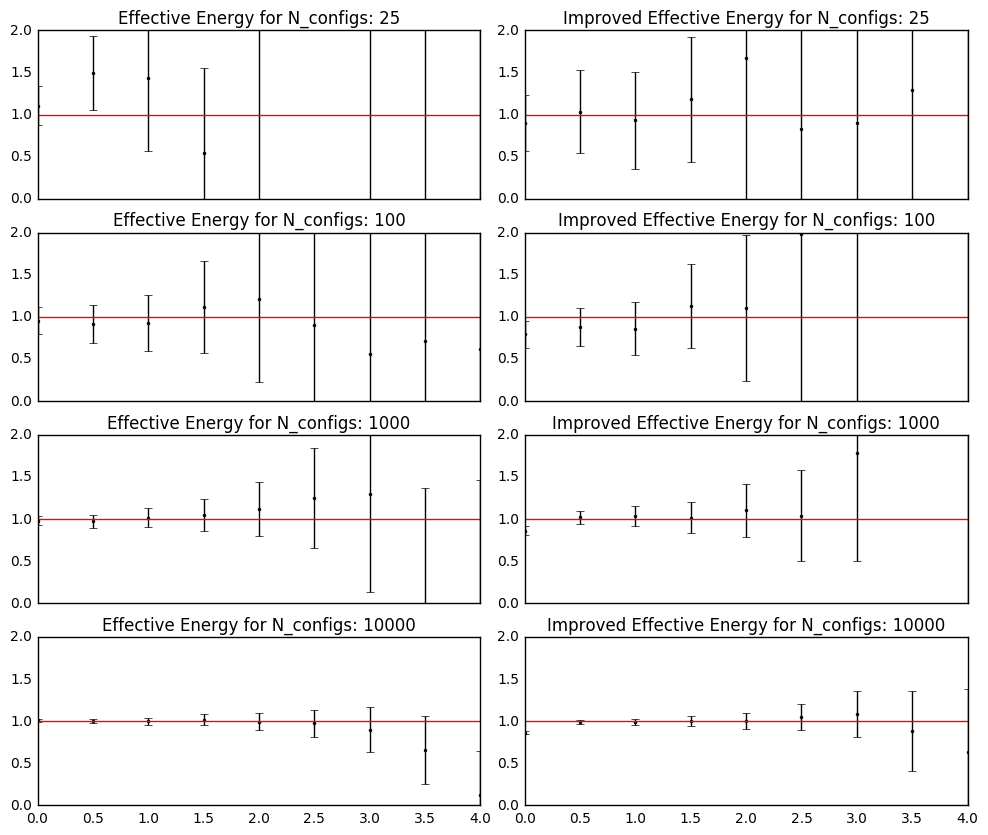

In [357]:
analysis(n_sites=20, n_cfs_arr=[25, 100, 1000, 10000], v=v_sho, m=1, a=0.5, dx=1.4, n_corr=20, bin_size = 1)

Doesn't seem that much better, improved action does however approach from below due to new states introduced in discretization.